---

_You are currently looking at **version 1.2** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 4

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [2]:
P1_Graphs = pickle.load(open('A4_graphs','rb'))
P1_Graphs

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs and determine which of the three algorithms generated the graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

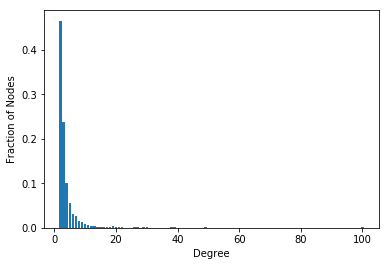

0.03167539146454044
4.099161161161161
Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 1996
Average degree:   3.9920


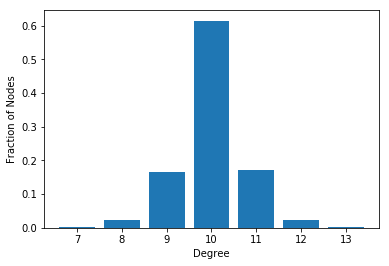

0.5642419635919628
5.089871871871872
Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 5000
Average degree:  10.0000


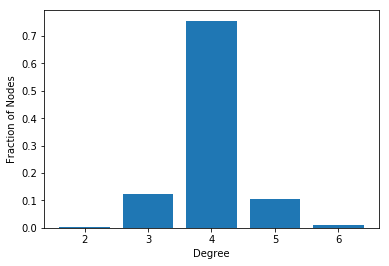

0.4018222222222227
9.378702269692925
Name: 
Type: Graph
Number of nodes: 750
Number of edges: 1500
Average degree:   4.0000


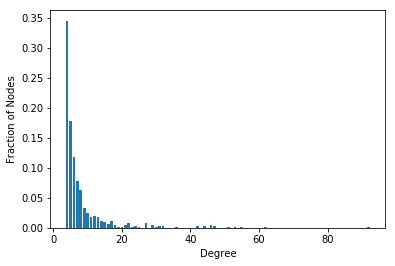

0.03780379975223251
3.1048046283934134
Name: 
Type: Graph
Number of nodes: 750
Number of edges: 2984
Average degree:   7.9573


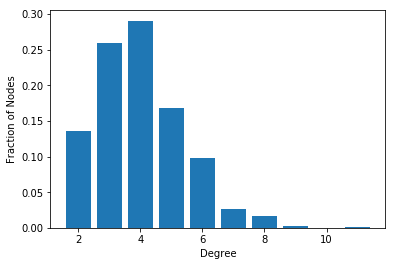

0.0033037037037037037
5.0785509568313305
Name: 
Type: Graph
Number of nodes: 750
Number of edges: 1500
Average degree:   4.0000


['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

In [7]:
def graph_identification():
    
    # Your Code Here
    import matplotlib.pyplot as plt
    
    for x in range(0,5):
        P = P1_Graphs[x]
    
        #plt.figure(figsize=(9,9))
        #nx.draw_networkx(P)
        #plt.show()
      
        G = nx.Graph()
        G.add_nodes_from(P.nodes())
        G.add_edges_from(P.edges())
        degrees = G.degree()
        degree_values = sorted(set(degrees.values()))
        histogram = [list(degrees.values()).count(i)/float(nx.number_of_nodes(G)) for i in degree_values]
    
        #plt.plot(degree_values, histogram, 'o')
        plt.bar(degree_values, histogram)
        plt.xlabel("Degree")
        plt.ylabel("Fraction of Nodes")
        #plt.xscale('log')
        #plt.yscale('log')
        plt.show()
    
        print(nx.average_clustering(G))
        print(nx.average_shortest_path_length(G))
        print (nx.info(G))
    
    return ['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

graph_identification()

---

## Part 2 - Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagementSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagementSalary` indicates whether that person is receiving a management position salary.

In [8]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


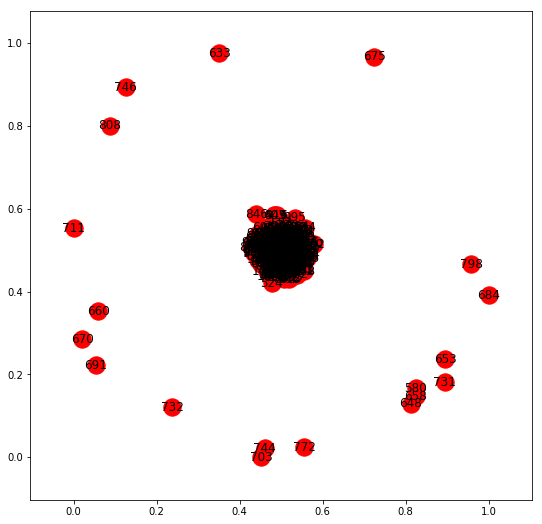

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9,9))
nx.draw_networkx(G)
plt.show()

### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a management position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a management salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a management position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 252 with the data being the probability of receiving management salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [11]:
def salary_predictions():
    
    # Your Code Here
    df = pd.DataFrame(index=G.nodes())
    df['Department'] = pd.Series(nx.get_node_attributes(G, 'Department'))
    df['ManagementSalary'] = pd.Series(nx.get_node_attributes(G, 'ManagementSalary'))
    
    df['clustering'] = pd.Series(nx.clustering(G))
    df['degree'] = pd.Series(G.degree())
    #df['weight'] = pd.Series(nx.get_edge_attributes(G, 'weight'))
    #df['preferential attachment'] = [i[2] for i in nx.preferential_attachment(G)]
    #df['Common Neighbors'] = df.index.map(lambda city: len(list(nx.common_neighbors(G, city[0], city[1]))))
    
    df_train = df[~df['ManagementSalary'].isnull()]
    df_test = df[['Department', 'clustering', 'degree']][df['ManagementSalary'].isnull()]
    
    X = df_train[['Department', 'clustering', 'degree']]
    y = df_train['ManagementSalary']
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import roc_auc_score
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    LR=LogisticRegression()
    
    grid_values = {'penalty': ['l1', 'l2'], 'C':[0.01, 0.1, 1, 10, 100]}
    grid_lr_custom = GridSearchCV(LR, param_grid = grid_values, scoring='roc_auc')
    
    grid_lr_custom.fit(X_train, y_train)
    scores = grid_lr_custom.cv_results_
    
    mean_scores = scores['mean_test_score']
    print(mean_scores.reshape(2,5))
    
    lr=LogisticRegression(penalty='l2', C=1.0)
    lr.fit(X_train, y_train)
    
    
    #auc = roc_auc_score(y, LR.predict_proba(X)[:, 1])
    #auc = roc_auc_score(y_test, LR.predict(X_test))
    
    prediction = lr.predict(df_test)
    probability = lr.predict_proba(df_test)[:,1]
    
    return pd.Series(data=probability, index=df_test.index)


salary_predictions()

[[ 0.54676134  0.66654525  0.84597761  0.81770605  0.88157692]
 [ 0.87150538  0.88199614  0.88340858  0.88080746  0.88157849]]


1       0.152228
2       0.575859
5       0.959082
8       0.128950
14      0.349769
18      0.181706
27      0.267684
30      0.319441
31      0.186903
34      0.128028
37      0.122387
40      0.242438
45      0.176897
54      0.242738
55      0.192064
60      0.209058
62      0.994337
65      0.441190
77      0.072671
79      0.126378
97      0.098401
101     0.083578
103     0.189990
108     0.127255
113     0.462545
122     0.066419
141     0.421395
142     0.906075
144     0.089320
145     0.412667
          ...   
913     0.068077
914     0.087417
915     0.017404
918     0.109099
923     0.051568
926     0.083773
931     0.071538
934     0.040976
939     0.028172
944     0.020041
945     0.049628
947     0.090918
950     0.157063
951     0.059083
953     0.048917
959     0.016026
962     0.017687
963     0.150889
968     0.079509
969     0.073792
974     0.061964
984     0.039417
987     0.089423
989     0.073582
991     0.095753
992     0.017351
994     0.019576
996     0.0180

### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [12]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)
#len(future_connections)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.88 or higher will receive full points, and with an AUC of 0.82 or higher will pass (get 80% of the full points).

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [20]:
def new_connections_predictions():
    
    # Your Code Here
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import roc_auc_score
    
    #add edge features
    #future_connections['weight'] = pd.Series(nx.get_edge_attributes(G, 'weight'))
    future_connections['preferential attachment'] = [i[2] for i in nx.preferential_attachment(G)]
    future_connections['Common Neighbors'] = future_connections.index.map(lambda city: len(list(nx.common_neighbors(G, city[0], city[1]))))
    
    #separate the future connections that are null
    future_connections_train = future_connections[~future_connections['Future Connection'].isnull()]
    future_connections_test = future_connections[['preferential attachment', 'Common Neighbors']][future_connections['Future Connection'].isnull()]
    
    #choose features and target
    X = future_connections_train[['preferential attachment', 'Common Neighbors']]
    y = future_connections_train['Future Connection']
      
    #train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    #cloose a model as a classifier
    LR=LogisticRegression() #initialize Logistic Regression model
    grid_values = {'penalty': ['l1', 'l2'], 'C':[0.01, 0.1, 1, 10, 100]} #set grid values for gred search
    grid_lr_custom = GridSearchCV(LR, param_grid = grid_values, scoring='roc_auc') #do Grid Search, scoring 'auc'
    LR_custom = grid_lr_custom.fit(X_train, y_train) #train the custom fit model on train set 
   
    #look at scores
    mean_scores = grid_lr_custom.cv_results_['mean_test_score'] #results are in cv_results_
    print(mean_scores.reshape(2,5))
    print(grid_lr_custom.best_params_)
    
    #predict the probabllity that there will be a future connection between edges
    probability = LR_custom.predict_proba(future_connections_test)[:,1]#calculate probabilities on test set
    
    #Check results with this if you want
    #lr=LogisticRegression(penalty='l1', C=0.01) #initialize model
    #lr.fit(X_train, y_train) #train model
    #prediction = lr.predict(future_connections_test) #we don't really need this here
    #probability = lr.predict_proba(future_connections_test)[:,1]#calculate probabilities
    
    return pd.Series(data=probability, index=future_connections_test.index)

new_connections_predictions()

[[ 0.9037399   0.9037202   0.90373887  0.90373926  0.90320946]
 [ 0.90373932  0.90373887  0.90373932  0.90320946  0.90373932]]
{'C': 0.01, 'penalty': 'l1'}


(107, 348)    0.037493
(542, 751)    0.014177
(20, 426)     0.673765
(50, 989)     0.014293
(942, 986)    0.014284
(324, 857)    0.014276
(13, 710)     0.220440
(19, 271)     0.220335
(319, 878)    0.014293
(659, 707)    0.014293
(49, 843)     0.014181
(208, 893)    0.014177
(377, 469)    0.014241
(405, 999)    0.023253
(129, 740)    0.023190
(292, 618)    0.023094
(239, 689)    0.014271
(359, 373)    0.014250
(53, 523)     0.037438
(276, 984)    0.014233
(202, 997)    0.014241
(604, 619)    0.037637
(270, 911)    0.014237
(261, 481)    0.095024
(200, 450)    0.771820
(213, 634)    0.013877
(644, 735)    0.037449
(346, 553)    0.014280
(521, 738)    0.014276
(422, 953)    0.023080
                ...   
(672, 848)    0.014297
(28, 127)     0.937737
(202, 661)    0.014297
(54, 195)     0.999237
(295, 864)    0.014295
(814, 936)    0.014293
(839, 874)    0.014297
(139, 843)    0.014297
(461, 544)    0.014297
(68, 487)     0.014297
(622, 932)    0.014296
(504, 936)    0.023264
(479, 528) 